In [1]:
import wandb
import os
import re

import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
%matplotlib inline


def calc_c95(table, value, group_name='name'):

    print(value)
    stats = table.groupby([group_name])[value].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(+ 1.96*s/np.sqrt(c))
        ci95_lo.append(- 1.96*s/np.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    print(stats)
    print('\n')

# Wideness

In [ ]:
name = 'mnist_plain_none_128_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        print(run.name, run.id)
        break

In [2]:
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == 'mnist_plain_none_128_0':
        run_train = run
        print(run.name, run.id)
    elif run.name == 'fgsm-mnist_plain_none_128_0':
        run_attack = run
        print(run.name, run.id)

baseline1 = pd.DataFrame()
history = run_train.history(samples=1000)
baseline1['train_acc'] = history['train_acc'].dropna()
baseline1['epoch'] = history['epoch'].dropna()

baseline2 = pd.DataFrame()
history = run_attack.history(samples=1000)
baseline2['attack_acc'] = history['attack_acc'].dropna()
baseline2['eps'] = history['eps'].dropna()

baseline1, baseline2

fgsm-mnist_plain_none_128_0 s8ljl7nv
mnist_plain_none_128_0 esvkp6qz


(     train_acc  epoch
 58    0.943180    1.0
 118   0.978911    2.0
 178   0.985924    3.0
 238   0.989228    4.0
 298   0.991144    5.0
 358   0.992915    6.0
 418   0.994553    7.0
 478   0.995236    8.0
 538   0.996219    9.0
 598   0.996768   10.0,
    attack_acc   eps
 0      0.9914  0.00
 1      0.9465  0.05
 2      0.7764  0.10
 3      0.4948  0.15
 4      0.2951  0.20
 5      0.1581  0.25
 6      0.0779  0.30)

In [3]:
# find runs
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
print(len(runs))

# for run in runs:
#     print(run.name)

72


In [4]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = '${}$'.format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
mnist_fc_none_1000    91.163331      1  NaN      NaN      NaN
mnist_fc_none_10000   97.938335      1  NaN      NaN      NaN
mnist_fc_none_100000  99.349999      1  NaN      NaN      NaN
mnist_fc_none_2000    94.046664      1  NaN      NaN      NaN
mnist_fc_none_20000   98.734999      1  NaN      NaN      NaN
mnist_fc_none_200000  99.444997      1  NaN      NaN      NaN
mnist_fc_none_5000    96.490002      1  NaN      NaN      NaN
mnist_fc_none_50000   99.185002      1  NaN      NaN      NaN


best_test_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
mnist_fc_none_1000    92.750001      1  NaN      NaN      NaN
mnist_fc_none_10000   97.119999      1  NaN      NaN      NaN
mnist_fc_none_100000  97.810000      1  NaN      NaN      NaN
mnist_fc_none_2000    94.779998      1 

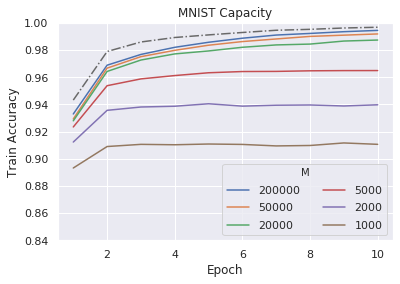

In [5]:
plt.plot(baseline1['epoch'], baseline1['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$50000$', '$20000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='MNIST Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.84, 1.0)
plt.legend(loc='lower right', ncol=2, title='M')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

In [6]:
ENV = 'fgsm-mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['M'] = "${}$".format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                            mean  count  std  ci95_hi  ci95_lo
name                                                          
fgsm-mnist_fc_none_1000     9.60      1  NaN      NaN      NaN
fgsm-mnist_fc_none_10000   17.31      1  NaN      NaN      NaN
fgsm-mnist_fc_none_100000  17.07      1  NaN      NaN      NaN
fgsm-mnist_fc_none_2000    12.09      1  NaN      NaN      NaN
fgsm-mnist_fc_none_20000   13.98      1  NaN      NaN      NaN
fgsm-mnist_fc_none_200000  18.10      1  NaN      NaN      NaN
fgsm-mnist_fc_none_5000    10.33      1  NaN      NaN      NaN
fgsm-mnist_fc_none_50000   19.38      1  NaN      NaN      NaN




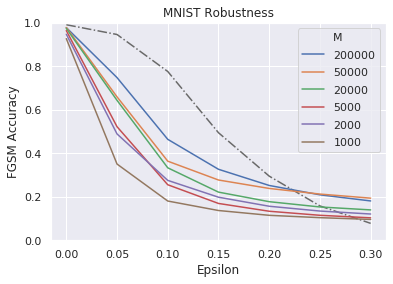

In [7]:
plt.plot(baseline2['eps'], baseline2['attack_acc'], '-.', color='dimgray')
ax = sns.lineplot(x='eps', y='attack_acc', hue='M', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$50000$', '$20000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='MNIST Robustness', xlabel='Epsilon', ylabel='FGSM Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

# LTD

In [8]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))

    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp['M'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)

        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count  std  ci95_hi  ci95_lo
name                                                         
mnist_fc_ma_1000      92.725003      1  NaN      NaN      NaN
mnist_fc_ma_10000     98.505002      1  NaN      NaN      NaN
mnist_fc_ma_100000    99.343336      1  NaN      NaN      NaN
mnist_fc_ma_2000      95.249999      1  NaN      NaN      NaN
mnist_fc_ma_20000     98.989999      1  NaN      NaN      NaN
mnist_fc_ma_200000    99.431664      1  NaN      NaN      NaN
mnist_fc_ma_5000      97.488332      1  NaN      NaN      NaN
mnist_fc_ma_50000     99.268335      1  NaN      NaN      NaN
mnist_fc_none_1000    91.163331      1  NaN      NaN      NaN
mnist_fc_none_10000   97.938335      1  NaN      NaN      NaN
mnist_fc_none_100000  99.349999      1  NaN      NaN      NaN
mnist_fc_none_2000    94.046664      1  NaN      NaN      NaN
mnist_fc_none_20000   98.734999      1  NaN      NaN      NaN
mnist_fc_none_200000  99.444997      1  NaN      NaN   

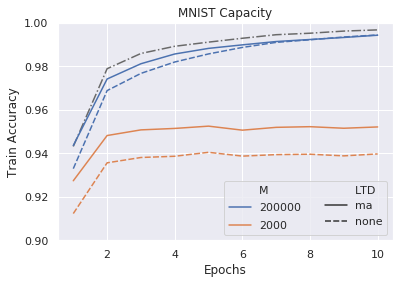

In [9]:
plt.plot(baseline1['epoch'], baseline1['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='M', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title='MNIST Capacity', xlabel='Epochs', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

In [10]:
ENV = 'fgsm-mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['M'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                            mean  count  std  ci95_hi  ci95_lo
name                                                          
fgsm-mnist_fc_ma_1000      30.92      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_10000     56.21      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_100000    66.28      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_2000      43.63      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_20000     60.07      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_200000    65.85      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_5000      53.27      1  NaN      NaN      NaN
fgsm-mnist_fc_ma_50000     66.57      1  NaN      NaN      NaN
fgsm-mnist_fc_none_1000     9.60      1  NaN      NaN      NaN
fgsm-mnist_fc_none_10000   17.31      1  NaN      NaN      NaN
fgsm-mnist_fc_none_100000  17.07      1  NaN      NaN      NaN
fgsm-mnist_fc_none_2000    12.09      1  NaN      NaN      NaN
fgsm-mnist_fc_none_20000   13.98      1  NaN      NaN      NaN
fgsm-mnist_fc_none_200000  18.10      1 

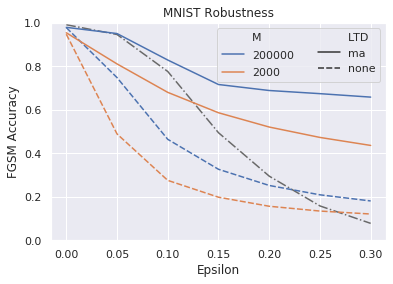

In [11]:
plt.plot(baseline2['eps'], baseline2['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='M', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title='MNIST Robustness', xlabel='Epsilon', ylabel='FGSM Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

# Sparseness and Inhibitory

In [12]:
ENV = 'mnist'
METHOD = ['rc', 'lc']
LTD = ['ma']
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        golgi = m.group(4)
        ltd = m.group(5)
        n = int(m.group(6))
        seed = int(m.group(7))

        if env == ENV and method in METHOD and k in K and ltd in LTD:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['best_train_acc'] = history['best_train_acc'].dropna()
            temp['best_test_acc'] = history['best_test_acc'].dropna()
            temp['Granule'] = method
            temp['K'] = k
            temp['golgi'] = golgi
            temp['seed'] = seed
            df = df.append(temp)

            best_train_acc = history['best_train_acc'].dropna().item() * 100
            best_test_acc = history['best_test_acc'].dropna().item() * 100
            name = run.name[:-2]
            table = table.append(pd.DataFrame(
                {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                                 mean  count  std  ci95_hi  ci95_lo
name                                                               
mnist_lc-1-none_ma_228571   91.158330      1  NaN      NaN      NaN
mnist_lc-10-none_ma_160000  96.773332      1  NaN      NaN      NaN
mnist_lc-100-none_ma_40000  98.718333      1  NaN      NaN      NaN
mnist_lc-2-none_ma_218182   94.215000      1  NaN      NaN      NaN
mnist_lc-20-none_ma_120000  97.556669      1  NaN      NaN      NaN
mnist_lc-200-none_ma_21818  98.898333      1  NaN      NaN      NaN
mnist_lc-4-none_ma_200000   95.573336      1  NaN      NaN      NaN
mnist_lc-400-none_ma_11429  98.658335      1  NaN      NaN      NaN
mnist_lc-50-none_ma_68571   98.361665      1  NaN      NaN      NaN
mnist_rc-1-none_ma_228571   91.018331      1  NaN      NaN      NaN
mnist_rc-10-none_ma_160000  97.563332      1  NaN      NaN      NaN
mnist_rc-100-none_ma_40000  98.671669      1  NaN      NaN      NaN
mnist_rc-2-none_ma_218182   94.76

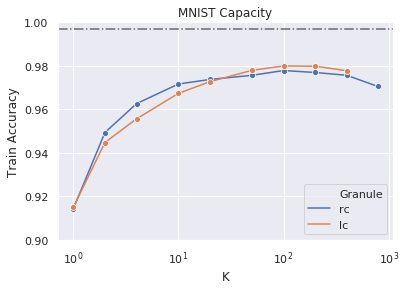

In [13]:
plt.axhline(0.997, linestyle='-.', color='dimgray')
ax = sns.lineplot(x='K', y='best_test_acc', hue='Granule', ci=95, n_boot=1000, marker='o',
                  hue_order=['rc', 'lc'],
                  data=df)
ax.set(title='MNIST Capacity', xlabel='K', xscale='log', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300)

In [15]:
ENV = 'fgsm-mnist'
METHOD = ['rc', 'lc']
LTD = ['ma']
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
SEED = [0, 1]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        golgi = m.group(4)
        ltd = m.group(5)
        n = int(m.group(6))
        seed = int(m.group(7))

        if env == ENV and method in METHOD and k in K and ltd in LTD and seed in SEED:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['max_attack_acc'] = history['max_attack_acc'].dropna()
            temp['K'] = k
            temp['Granule'] = method
            temp['golgi'] = golgi
            temp['seed'] = seed
            df = df.append(temp)

            max_attack_acc = history['max_attack_acc'].dropna().item() * 100
            name = run.name[:-2]
            table = table.append(pd.DataFrame(
                {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                                  mean  count  std  ci95_hi  ci95_lo
name                                                                
fgsm-mnist_lc-1-none_ma_228571   47.91      1  NaN      NaN      NaN
fgsm-mnist_lc-10-none_ma_160000  74.14      1  NaN      NaN      NaN
fgsm-mnist_lc-100-none_ma_40000  77.50      1  NaN      NaN      NaN
fgsm-mnist_lc-2-none_ma_218182   64.04      1  NaN      NaN      NaN
fgsm-mnist_lc-20-none_ma_120000  77.84      1  NaN      NaN      NaN
fgsm-mnist_lc-200-none_ma_21818  68.45      1  NaN      NaN      NaN
fgsm-mnist_lc-4-none_ma_200000   71.20      1  NaN      NaN      NaN
fgsm-mnist_lc-400-none_ma_11429  62.17      1  NaN      NaN      NaN
fgsm-mnist_lc-50-none_ma_68571   75.31      1  NaN      NaN      NaN
fgsm-mnist_rc-1-none_ma_228571   49.27      1  NaN      NaN      NaN
fgsm-mnist_rc-10-none_ma_160000  82.39      1  NaN      NaN      NaN
fgsm-mnist_rc-100-none_ma_40000  73.01      1  NaN      NaN      NaN
fgsm-mnist_rc-2-non

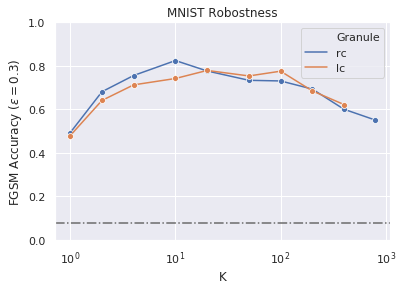

In [16]:
plt.axhline(0.0779, linestyle='-.', color='dimgray')
ax = sns.lineplot(x='K', y='max_attack_acc', hue='Granule', ci=95, n_boot=1000, marker='o',
                  hue_order=['rc', 'lc'],
                  data=df)
ax.set(title='MNIST Robostness', xlabel='K', xscale='log', ylabel='FGSM Accuracy ($\epsilon=0.3$)')
plt.ylim(0, 1.0)
# plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300)

# Best Model

In [ ]:
ENV = 'fgsm-mnist'
METHOD = 'rc'
LTD = 'ma'
K = 10

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        golgi = m.group(4)
        ltd = m.group(5)
        n = int(m.group(6))
        seed = int(m.group(7))
    
    if env == ENV and method == METHOD  and k == K and ltd == LTD:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['M'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = run.name[:-2]
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')